In [1]:
import os
from matplotlib import pyplot as plt
import rasterio
import shapely
import geopandas as gpd
import shutil
import glob
from sklearn.model_selection import train_test_split 
from pyimpute import load_training_vector
from pyimpute import load_targets
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
import pandas as pd
from pyimpute import impute
from sklearn import model_selection as mod_sel
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix as evaluate_conf
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
os.chdir("/Users/pranavkulkarni/SDM/Climate_Models_Arenaviruses")
os.getcwd()

'/Users/pranavkulkarni/SDM/Climate_Models_Arenaviruses'

In [3]:
pa = gpd.GeoDataFrame.from_file("./Data/Input/Processed/GBIF/zyg.shp")

raster_features = sorted(glob.glob("./Data/Input/Processed/Resampled/guan/*.tif"))
print('number of raster features = ', len(raster_features), '; pa.shape = ', pa.shape)

number of raster features =  26 ; pa.shape =  (3095, 2)


In [4]:
pa_train, pa_test = train_test_split(pa, test_size=0.25, stratify=pa['CLASS'])
print(pa_train.shape, pa_test.shape)

(2321, 2) (774, 2)


In [5]:
train_xs, train_y = load_training_vector(pa_train, raster_features, response_field = "CLASS")
target_xs, raster_info = load_targets(raster_features)
imputer = SimpleImputer(missing_values = np.nan, strategy = "mean")

impute_train = imputer.fit(train_xs)
train_xs = impute_train.transform(train_xs)

target_xs[np.isnan(target_xs)] = 0
print(train_xs.shape)

(2321, 26)


In [6]:
test_xs, test_y = load_training_vector(pa_test, raster_features, response_field = "CLASS")
test_target_xs, test_raster_info = load_targets(raster_features)
impute_train = imputer.fit(test_xs)
test_xs = impute_train.transform(test_xs)

test_target_xs[np.isnan(test_target_xs)] = 0
print({'test_xs': test_xs.shape, 'test_target_xs': test_target_xs.shape})

{'test_xs': (774, 26), 'test_target_xs': (405000, 26)}


In [7]:
raster_features

['./Data/Input/Processed/Resampled/guan/bclim_01.tif',
 './Data/Input/Processed/Resampled/guan/bclim_02.tif',
 './Data/Input/Processed/Resampled/guan/bclim_03.tif',
 './Data/Input/Processed/Resampled/guan/bclim_04.tif',
 './Data/Input/Processed/Resampled/guan/bclim_05.tif',
 './Data/Input/Processed/Resampled/guan/bclim_06.tif',
 './Data/Input/Processed/Resampled/guan/bclim_07.tif',
 './Data/Input/Processed/Resampled/guan/bclim_08.tif',
 './Data/Input/Processed/Resampled/guan/bclim_09.tif',
 './Data/Input/Processed/Resampled/guan/bclim_10.tif',
 './Data/Input/Processed/Resampled/guan/bclim_11.tif',
 './Data/Input/Processed/Resampled/guan/bclim_12.tif',
 './Data/Input/Processed/Resampled/guan/bclim_13.tif',
 './Data/Input/Processed/Resampled/guan/bclim_14.tif',
 './Data/Input/Processed/Resampled/guan/bclim_15.tif',
 './Data/Input/Processed/Resampled/guan/bclim_16.tif',
 './Data/Input/Processed/Resampled/guan/bclim_17.tif',
 './Data/Input/Processed/Resampled/guan/bclim_18.tif',
 './Data/I

In [8]:
feature_names = ["Annual Mean Temperature",
                "Mean Diurnal Range",
                "Isothermality",
                "Temperature Seasonality",
                "Max Temperature of Warmest Month",
                "Min Temperature of Coldest Month",
                "Temperature Annual Range",
                "Mean Temperature of Wettest Quarter",
                "Mean Temperature of Driest Quarter",
                 "Mean Temperature of Warmest Quarter",
                 "Mean Temperature of Coldest Quarter",
                "Annual Precipitation",
                "Precipitation of Wettest Month",
                "Precipitation of Driest Month",
                "Precipitation Seasonality",
                "Precipitation of Wettest Quarter",
                "Precipitation of Driest Quarter",
                 "Precipitation of Warmest Quarter",
                "Precipitation of Coldest Quarter",
                 "DEM",
                 "LUcrop",
                "LUothr",
                "LUpast",
                "LUsecd",
                "LUurbn",
                "NDVI"]

In [9]:
CLASS_MAP = {
    "rf": (RandomForestClassifier()),
    "et": (ExtraTreesClassifier()),
    "xgb": (XGBClassifier()),
    "lgbm": (LGBMClassifier(verbose = -1))
}

In [10]:
# selected_features = []
# for name, (model) in CLASS_MAP.items():
#     rfe = RFE(estimator = model, n_features_to_select = 10)
#     pipeline = Pipeline(steps=[('Feature Selection', rfe), ('Model', model)])
#     k = 5
#     kf = mod_sel.KFold(n_splits = k)
#     accu_score = mod_sel.cross_val_score(pipeline, train_xs, train_y, cv = kf, scoring = "accuracy")
#     print(name + "CV Accuracy: %0.2f (+/- %0.2f)"
#                     % (accu_score.mean() * 100, accu_score.std() * 200))
#     accuracy_scores = mod_sel.cross_val_score(pipeline, train_xs, train_y, cv=kf, scoring='roc_auc')
#     print(name + "CV AUC_ROC: %0.2f (+/- %0.2f)"
#                     % (accuracy_scores.mean() * 100, accuracy_scores.std() * 200))
#     accuracy_scores_p = mod_sel.cross_val_score(pipeline, train_xs, train_y, cv=kf, scoring='precision')
#     print(name + "CV precision: %0.2f (+/- %0.2f)"
#                     % (accuracy_scores_p.mean() * 100, accuracy_scores_p.std() * 200))
#     accuracy_scores_r = mod_sel.cross_val_score(pipeline, train_xs, train_y, cv=kf, scoring='recall')
#     print(name + "CV recall: %0.2f (+/- %0.2f)"
#                     % (accuracy_scores_r.mean() * 100, accuracy_scores_r.std() * 200))
#     pipeline.fit(train_xs, train_y)
#     y_pred = pipeline.predict(test_xs)
#     eval1 = evaluate_conf(test_y, y_pred)
#     print(eval1)
#     selector = rfe.fit(train_xs, train_y)   
#     selt = selector.support_
#     selected_features.append(selt)

rfCV Accuracy: 91.77 (+/- 2.02)
rfCV AUC_ROC: 94.37 (+/- 1.21)
rfCV precision: 84.62 (+/- 7.04)
rfCV recall: 72.69 (+/- 4.91)
[[604  15]
 [ 48 107]]
etCV Accuracy: 92.24 (+/- 1.79)
etCV AUC_ROC: 94.18 (+/- 1.88)
etCV precision: 83.47 (+/- 6.24)
etCV recall: 75.70 (+/- 6.44)
[[593  26]
 [ 44 111]]
xgbCV Accuracy: 91.43 (+/- 1.18)
xgbCV AUC_ROC: 94.36 (+/- 1.77)
xgbCV precision: 80.52 (+/- 5.60)
xgbCV recall: 75.22 (+/- 7.16)
[[593  26]
 [ 44 111]]
lgbmCV Accuracy: 91.25 (+/- 1.12)
lgbmCV AUC_ROC: 93.90 (+/- 1.86)
lgbmCV precision: 82.54 (+/- 7.39)
lgbmCV recall: 71.30 (+/- 7.01)
[[600  19]
 [ 43 112]]


In [11]:
# sel_feats = pd.DataFrame(selected_features)
# sel_feats.columns = feature_names
# sel_feats.index = ('rf_sel','et_sel','xgb_sel','lgbm_sel')
# sel_feats = sel_feats.T

In [12]:
# raster_features_np = np.array(raster_features)
# raster_features_rf = raster_features_np[sel_feats.rf_sel]
# raster_features_et = raster_features_np[sel_feats.et_sel]
# raster_features_xgb = raster_features_np[sel_feats.xgb_sel]
# raster_features_lgbm = raster_features_np[sel_feats.lgbm_sel]
# raster_features_lgbm

array(['./Data/Input/Processed/Resampled/guan/bclim_02.tif',
       './Data/Input/Processed/Resampled/guan/bclim_03.tif',
       './Data/Input/Processed/Resampled/guan/bclim_04.tif',
       './Data/Input/Processed/Resampled/guan/bclim_06.tif',
       './Data/Input/Processed/Resampled/guan/bclim_17.tif',
       './Data/Input/Processed/Resampled/guan/bclim_18.tif',
       './Data/Input/Processed/Resampled/guan/bclim_19.tif',
       './Data/Input/Processed/Resampled/guan/dem.tif',
       './Data/Input/Processed/Resampled/guan/lu_past.tif',
       './Data/Input/Processed/Resampled/guan/ndvi.tif'], dtype='<U50')

In [13]:
# sel_feats

,rf_sel,et_sel,xgb_sel,lgbm_sel
Annual Mean Temperature,False,False,False,False
Mean Diurnal Range,True,True,True,True
Isothermality,False,True,True,True
Temperature Seasonality,False,True,True,True
Max Temperature of Warmest Month,False,False,False,False
Min Temperature of Coldest Month,False,False,True,True
Temperature Annual Range,True,True,False,False
Mean Temperature of Wettest Quarter,False,False,False,False
Mean Temperature of Driest Quarter,False,False,False,False
Mean Temperature of Warmest Quarter,True,False,False,False


In [14]:
model_out = []
feature_imp = pd.DataFrame({'features' : feature_names})
for name, (model) in CLASS_MAP.items():
    k = 5
    kf = mod_sel.KFold(n_splits = k)
    accu_score = mod_sel.cross_val_score(model, train_xs, train_y, cv = kf, scoring = "accuracy")
    accuracy_scores = mod_sel.cross_val_score(model, train_xs, train_y, cv=kf, scoring='roc_auc')
    accuracy_scores_p = mod_sel.cross_val_score(model, train_xs, train_y, cv=kf, scoring='precision')
    accuracy_scores_r = mod_sel.cross_val_score(model, train_xs, train_y, cv=kf, scoring='recall')
    model.fit(train_xs, train_y)
    if os.path.exists("./Data/Output/SDMs/Z_brevicauda/Current"):
        print('name folders exists')
    else: 
        os.mkdir("./Data/Output/SDMs/Z_brevicauda/Current")
    impute(target_xs, model, raster_info, 
        outdir = "./Data/Output/SDMs/Z_brevicauda/Current/" + name + "-images",
        class_prob = True, 
        certainty = True)
    y_pred = model.predict(test_xs)
    eval1 = evaluate_conf(test_y, y_pred)
    mod_scores = [str(name + "CV Accuracy: %0.2f (+/- %0.2f)"
                    % (accu_score.mean() * 100, accu_score.std() * 200)),
                str(name + "CV AUC_ROC: %0.2f (+/- %0.2f)"
                    % (accuracy_scores.mean() * 100, accuracy_scores.std() * 200)),
                str(name + "CV precision: %0.2f (+/- %0.2f)"
                    % (accuracy_scores_p.mean() * 100, accuracy_scores_p.std() * 200)),
                str(name + "CV recall: %0.2f (+/- %0.2f)"
                    % (accuracy_scores_r.mean() * 100, accuracy_scores_r.std() * 200)),
                str(eval1)]
    feat_imp = model.fit(train_xs, train_y).feature_importances_
    model_out.append(mod_scores)
    feature_imp[str(name)] = feat_imp

name folders exists
name folders exists
name folders exists
name folders exists


In [15]:
model_out

[['rfCV Accuracy: 92.12 (+/- 1.49)',
  'rfCV AUC_ROC: 94.54 (+/- 1.15)',
  'rfCV precision: 87.25 (+/- 6.60)',
  'rfCV recall: 71.57 (+/- 6.35)',
  '[[603  16]\n [ 45 110]]'],
 ['etCV Accuracy: 92.46 (+/- 1.26)',
  'etCV AUC_ROC: 94.79 (+/- 1.39)',
  'etCV precision: 85.32 (+/- 4.14)',
  'etCV recall: 72.91 (+/- 7.09)',
  '[[604  15]\n [ 49 106]]'],
 ['xgbCV Accuracy: 91.55 (+/- 1.24)',
  'xgbCV AUC_ROC: 94.46 (+/- 1.42)',
  'xgbCV precision: 81.85 (+/- 5.38)',
  'xgbCV recall: 74.07 (+/- 7.76)',
  '[[599  20]\n [ 48 107]]'],
 ['lgbmCV Accuracy: 91.90 (+/- 1.47)',
  'lgbmCV AUC_ROC: 94.54 (+/- 1.99)',
  'lgbmCV precision: 84.13 (+/- 6.39)',
  'lgbmCV recall: 73.31 (+/- 6.26)',
  '[[602  17]\n [ 49 106]]']]

In [16]:
feature_imp

,features,rf,et,xgb,lgbm
0,Annual Mean Temperature,0.029439,0.028815,0.030698,66
1,Mean Diurnal Range,0.046286,0.046901,0.035266,166
2,Isothermality,0.029492,0.037436,0.035390,162
3,Temperature Seasonality,0.032280,0.034980,0.033743,139
4,Max Temperature of Warmest Month,0.029295,0.027411,0.030292,95
5,Min Temperature of Coldest Month,0.033498,0.027591,0.040001,129
6,Temperature Annual Range,0.036702,0.038604,0.012578,136
7,Mean Temperature of Wettest Quarter,0.029040,0.029761,0.030329,100
8,Mean Temperature of Driest Quarter,0.025889,0.026368,0.018479,98
9,Mean Temperature of Warmest Quarter,0.032257,0.025707,0.031092,63


In [30]:
feature_imp.to_csv("./Data/Output/SDMs/Z_brevicauda/Current/feature_imp.csv")
with open("./Data/Output/SDMs/Z_brevicauda/Current/model_out.txt", "w") as output:
    output.write(str(model_out))

In [17]:
distr_rf = rasterio.open("./Data/Output/SDMs/Z_brevicauda/Current/rf-images/probability_1.0.tif").read(1)
distr_et = rasterio.open("./Data/Output/SDMs/Z_brevicauda/Current/et-images/probability_1.0.tif").read(1)
distr_xgb =  rasterio.open("./Data/Output/SDMs/Z_brevicauda/Current/xgb-images/probability_1.tif").read(1)
distr_lgbm =  rasterio.open("./Data/Output/SDMs/Z_brevicauda/Current/lgbm-images/probability_1.0.tif").read(1)
distr_averaged = (distr_rf + distr_et + distr_xgb + distr_lgbm)/4  

In [18]:
ssp2 = sorted(glob.glob("./Data/Input/Processed/Projected/guan/SSP2/*.tif"))
ssp2

['./Data/Input/Processed/Projected/guan/SSP2/bclim_01.tif',
 './Data/Input/Processed/Projected/guan/SSP2/bclim_02.tif',
 './Data/Input/Processed/Projected/guan/SSP2/bclim_03.tif',
 './Data/Input/Processed/Projected/guan/SSP2/bclim_04.tif',
 './Data/Input/Processed/Projected/guan/SSP2/bclim_05.tif',
 './Data/Input/Processed/Projected/guan/SSP2/bclim_06.tif',
 './Data/Input/Processed/Projected/guan/SSP2/bclim_07.tif',
 './Data/Input/Processed/Projected/guan/SSP2/bclim_08.tif',
 './Data/Input/Processed/Projected/guan/SSP2/bclim_09.tif',
 './Data/Input/Processed/Projected/guan/SSP2/bclim_10.tif',
 './Data/Input/Processed/Projected/guan/SSP2/bclim_11.tif',
 './Data/Input/Processed/Projected/guan/SSP2/bclim_12.tif',
 './Data/Input/Processed/Projected/guan/SSP2/bclim_13.tif',
 './Data/Input/Processed/Projected/guan/SSP2/bclim_14.tif',
 './Data/Input/Processed/Projected/guan/SSP2/bclim_15.tif',
 './Data/Input/Processed/Projected/guan/SSP2/bclim_16.tif',
 './Data/Input/Processed/Projected/guan/

In [19]:
ssp5 = sorted(glob.glob("./Data/Input/Processed/Projected/guan/SSP5/*.tif"))
ssp5

['./Data/Input/Processed/Projected/guan/SSP5/bclim_01.tif',
 './Data/Input/Processed/Projected/guan/SSP5/bclim_02.tif',
 './Data/Input/Processed/Projected/guan/SSP5/bclim_03.tif',
 './Data/Input/Processed/Projected/guan/SSP5/bclim_04.tif',
 './Data/Input/Processed/Projected/guan/SSP5/bclim_05.tif',
 './Data/Input/Processed/Projected/guan/SSP5/bclim_06.tif',
 './Data/Input/Processed/Projected/guan/SSP5/bclim_07.tif',
 './Data/Input/Processed/Projected/guan/SSP5/bclim_08.tif',
 './Data/Input/Processed/Projected/guan/SSP5/bclim_09.tif',
 './Data/Input/Processed/Projected/guan/SSP5/bclim_10.tif',
 './Data/Input/Processed/Projected/guan/SSP5/bclim_11.tif',
 './Data/Input/Processed/Projected/guan/SSP5/bclim_12.tif',
 './Data/Input/Processed/Projected/guan/SSP5/bclim_13.tif',
 './Data/Input/Processed/Projected/guan/SSP5/bclim_14.tif',
 './Data/Input/Processed/Projected/guan/SSP5/bclim_15.tif',
 './Data/Input/Processed/Projected/guan/SSP5/bclim_16.tif',
 './Data/Input/Processed/Projected/guan/

In [20]:
target_ssp2, ssp2_info = load_targets(ssp2)
target_ssp2[np.isnan(target_ssp2)] = 0

target_ssp5, ssp5_info = load_targets(ssp5)
target_ssp5[np.isnan(target_ssp5)] = 0
print(target_ssp2.shape, target_ssp5.shape)

(405000, 26) (405000, 26)


In [21]:
for name, (model) in CLASS_MAP.items():
    model.fit(train_xs, train_y) 
    if os.path.exists("./Data/Output/SDMs/Z_brevicauda/Projected/ssp2"):
        print('name folders exists')
    else: 
        os.mkdir("./Data/Output/SDMs/Z_brevicauda/Projected/ssp2")
    impute(target_ssp2, model, ssp2_info, 
        outdir = "./Data/Output/SDMs/Z_brevicauda/Projected/ssp2/" + name + "-images",
        class_prob = True, 
        certainty = True)

    if os.path.exists("./Data/Output/SDMs/Z_brevicauda/Projected/ssp5"):
        print('name folders exists')
    else: 
        os.mkdir("./Data/Output/SDMs/Z_brevicauda/Projected/ssp5")
    impute(target_ssp5, model, ssp5_info, 
        outdir = "./Data/Output/SDMs/Z_brevicauda/Projected/ssp5/" + name + "-images",
        class_prob = True, 
        certainty = True)

name folders exists
name folders exists
name folders exists
name folders exists
name folders exists
name folders exists
name folders exists
name folders exists


In [22]:
distr_rf = rasterio.open("./Data/Output/SDMs/Z_brevicauda/Projected/ssp2/rf-images/probability_1.0.tif").read(1)
distr_et = rasterio.open("./Data/Output/SDMs/Z_brevicauda/Projected/ssp2/et-images/probability_1.0.tif").read(1)
distr_xgb =  rasterio.open("./Data/Output/SDMs/Z_brevicauda/Projected/ssp2/xgb-images/probability_1.tif").read(1)
distr_lgbm =  rasterio.open("./Data/Output/SDMs/Z_brevicauda/Projected/ssp2/lgbm-images/probability_1.0.tif").read(1)
distr_averaged_ssp2 = (distr_rf + distr_et + distr_xgb + distr_lgbm)/4  

In [23]:
distr_rf = rasterio.open("./Data/Output/SDMs/Z_brevicauda/Projected/ssp5/rf-images/probability_1.0.tif").read(1)
distr_et = rasterio.open("./Data/Output/SDMs/Z_brevicauda/Projected/ssp5/et-images/probability_1.0.tif").read(1)
distr_xgb =  rasterio.open("./Data/Output/SDMs/Z_brevicauda/Projected/ssp5/xgb-images/probability_1.tif").read(1)
distr_lgbm =  rasterio.open("./Data/Output/SDMs/Z_brevicauda/Projected/ssp5/lgbm-images/probability_1.0.tif").read(1)
distr_averaged_ssp5 = (distr_rf + distr_et + distr_xgb + distr_lgbm)/4  

In [24]:
meta = rasterio.open("./Data/Output/SDMs/Z_brevicauda/Projected/ssp2/rf-images/probability_1.0.tif").meta.copy()

with rasterio.open("./Data/Output/SDMs/Z_brevicauda/Projected/ssp2/merged_ssp2.tif", 'w', **meta) as dst:
    dst.write(distr_averaged_ssp2.astype(rasterio.float32),1)
    
meta = rasterio.open("./Data/Output/SDMs/Z_brevicauda/Projected/ssp5/rf-images/probability_1.0.tif").meta.copy()

with rasterio.open("./Data/Output/SDMs/Z_brevicauda/Projected/ssp5/merged_ssp5.tif", 'w', **meta) as dst:
    dst.write(distr_averaged_ssp5.astype(rasterio.float32),1)

meta = rasterio.open("./Data/Output/SDMs/Z_brevicauda/Current/rf-images/probability_1.0.tif").meta.copy()

with rasterio.open("./Data/Output/SDMs/Z_brevicauda/Current/merged_current.tif", 'w', **meta) as dst:
    dst.write(distr_averaged.astype(rasterio.float32),1)


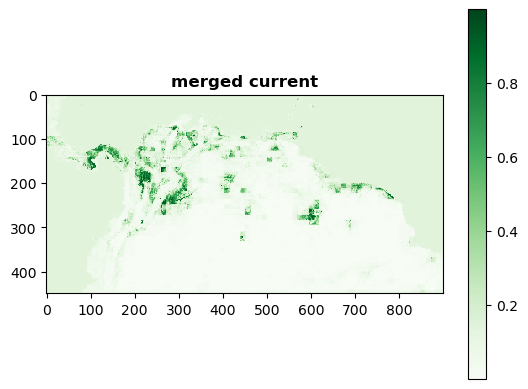

In [25]:
import matplotlib.pyplot as plt
def plotit(x, title, cmap = "Greens"):
    plt.imshow(x, cmap = cmap, interpolation = "nearest")
    plt.colorbar()
    plt.title(title, fontweight = "bold")


plotit(rasterio.open("./Data/Output/SDMs/Z_brevicauda/Current/merged_current.tif").read(1), 
       "merged current", cmap = "Greens")

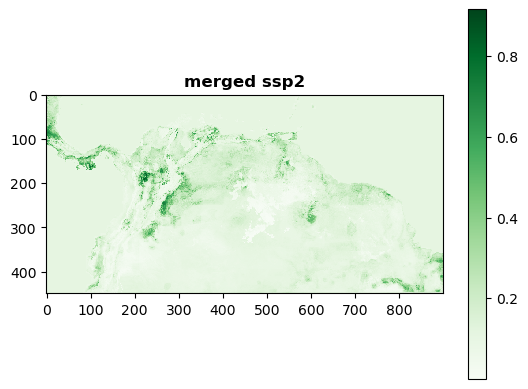

In [26]:
plotit(rasterio.open("./Data/Output/SDMs/Z_brevicauda/Projected/ssp2/merged_ssp2.tif").read(1), 
       "merged ssp2", cmap = "Greens")


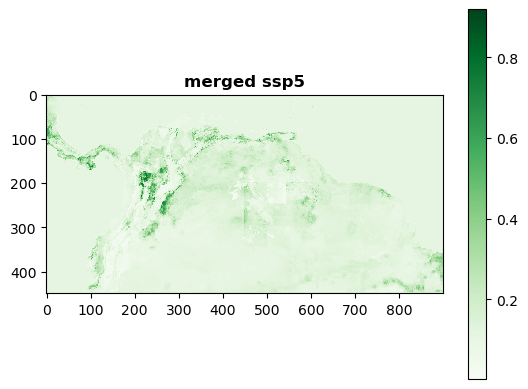

In [27]:
plotit(rasterio.open("./Data/Output/SDMs/Z_brevicauda/Projected/ssp5/merged_ssp5.tif").read(1), 
       "merged ssp5", cmap = "Greens")

In [28]:
distr_averaged.shape

(450, 900)